# Tugas Besar 1 - Kelompok 29

Kelompok 29
- Erdianti Wiga Putri Andini | 13522053
- Shazya Audrea Taufik | 13522063
- Zahira Dina Amalia | 13522085

## Analisis Implementasi FFNN Terhadap Berbagai Kondisi
1. Depth dan width
2. Fungsi aktivasi
3. Variasi learning rate
4. Metode inisialisasi bobot
5. Perbandingan dengan implementasi MLP sklearn

In [1]:
%pip install ipywidgets
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from tqdm.notebook import trange
import networkx as nx

from ffnn_imp import FeedForwardNN

# random seed
np.random.seed(42)

Note: you may need to restart the kernel to use updated packages.


### Load and Prepare MNIST Dataset

In [2]:
# load dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# scaling fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

# encode fitur
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Training data shape: (56000, 784)
Training labels shape: (56000, 10)


### Helper Functions for Analysis

In [3]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test, batch_size=32, learning_rate=0.01, epochs=10, verbose=1):
    start_time = time.time()
    
    history = model.train(
        X_train, y_train,
        X_val=X_test, y_val=y_test,
        batch_size=batch_size,
        learning_rate=learning_rate,
        epochs=epochs,
        verbose=verbose
    )
    
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
    
    return {
        'model': model,
        'history': history,
        'accuracy': accuracy,
        'training_time': training_time,
        'y_pred': y_pred
    }

def plot_training_history(results, title, y_label='Loss'):
    plt.figure(figsize=(12, 6))
    
    for result in results:
        label = result['label']
        history = result['history']
        plt.plot(history['train_loss'], label=f'{label} (train)')
        plt.plot(history['val_loss'], label=f'{label} (val)', linestyle='--')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_accuracies(results, title):
    labels = [result['label'] for result in results]
    accuracies = [result['accuracy'] * 100 for result in results]
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, accuracies)
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    
    # Add accuracy values on top of bars
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()

def compare_weights_and_gradients(results, layer_idx=0):
    n_models = len(results)
    fig, axs = plt.subplots(n_models, 2, figsize=(12, 4 * n_models))
    
    for i, result in enumerate(results):
        model = result['model']
        label = result['label']
        
        # Plot weight distribution
        weights = model.layers[layer_idx].weights.flatten()
        axs[i, 0].hist(weights, bins=50, alpha=0.7)
        axs[i, 0].set_title(f"{label} - Layer {layer_idx+1} Weight Distribution")
        axs[i, 0].set_xlabel("Weight Value")
        axs[i, 0].set_ylabel("Frequency")
        axs[i, 0].grid(True, alpha=0.3)
        
        # Plot gradient distribution
        gradients = model.layers[layer_idx].weights_gradient.flatten()
        axs[i, 1].hist(gradients, bins=50, alpha=0.7, color='red')
        axs[i, 1].set_title(f"{label} - Layer {layer_idx+1} Gradient Distribution")
        axs[i, 1].set_xlabel("Gradient Value")
        axs[i, 1].set_ylabel("Frequency")
        axs[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 1. Analisis Pengaruh Depth dan Width

In [4]:
common_params = {
    'batch_size': 32,
    'learning_rate': 0.01,
    'epochs': 10,
    'verbose': 1
}

# 1. Width
print("\n=== Analisis Pengaruh Network Width ===")

width_results = []

# Depth tetap (3 layers: input -> hidden -> output), width divariasikan
width_configs = [
    {'dimensions': [784, 32, 10], 'label': 'Width 32'},
    {'dimensions': [784, 64, 10], 'label': 'Width 64'},
    {'dimensions': [784, 128, 10], 'label': 'Width 128'}
]

for config in width_configs:
    print(f"\nModel dengan {config['label']}")
    model = FeedForwardNN(
        layer_dimensions=config['dimensions'],
        activations=['relu', 'softmax'],
        loss='categorical_cross_entropy',
        weight_initializer='random_normal',
        weight_init_params={'mean': 0.0, 'variance': 0.01, 'seed': 42}
    )
    
    result = train_and_evaluate(
        model, X_train, y_train, X_test, y_test, batch_size=common_params['batch_size'], learning_rate=common_params['learning_rate'], epochs=common_params['epochs'], verbose=common_params['verbose']
    )
    
    result['label'] = config['label']
    width_results.append(result)
    print(f"Akurasi: {result['accuracy'] * 100:.2f}%, Waktu latih: {result['training_time']:.2f} detik")

# 2. Depth
print("\n=== Analisis Pengaruh Network Depth ===")

depth_results = []

# Width tetap (64 neurons per hidden layer), depth divariasikan
depth_configs = [
    {'dimensions': [784, 64, 10], 'activations': ['relu', 'softmax'], 'label': '1 Hidden Layer'},
    {'dimensions': [784, 64, 64, 10], 'activations': ['relu', 'relu', 'softmax'], 'label': '2 Hidden Layers'},
    {'dimensions': [784, 64, 64, 64, 10], 'activations': ['relu', 'relu', 'relu', 'softmax'], 'label': '3 Hidden Layers'}
]

for config in depth_configs:
    print(f"\nModel dengan {config['label']}")
    model = FeedForwardNN(
        layer_dimensions=config['dimensions'],
        activations=config['activations'],
        loss='categorical_cross_entropy',
        weight_initializer='random_normal',
        weight_init_params={'mean': 0.0, 'variance': 0.01, 'seed': 42}
    )
    
    result = train_and_evaluate(
        model, X_train, y_train, X_test, y_test, **common_params
    )
    
    result['label'] = config['label']
    depth_results.append(result)
    print(f"Akurasi: {result['accuracy'] * 100:.2f}%, Waktu latih: {result['training_time']:.2f} detik")


=== Analisis Pengaruh Network Width ===

Model dengan Width 32


Epoch 1/10 - Train Loss: 2.8396 - Val Loss: 4.7575
Epoch 2/10 - Train Loss: 5.3171 - Val Loss: 5.8337
Epoch 3/10 - Train Loss: 6.3133 - Val Loss: 5.9308
Epoch 4/10 - Train Loss: 6.2669 - Val Loss: 4.4901
Epoch 5/10 - Train Loss: 6.1009 - Val Loss: 5.3196
Epoch 6/10 - Train Loss: 6.3861 - Val Loss: 6.9163
Epoch 7/10 - Train Loss: 6.0990 - Val Loss: 9.6206
Epoch 8/10 - Train Loss: 6.3430 - Val Loss: 5.2979
Epoch 9/10 - Train Loss: 6.1291 - Val Loss: 5.7470
Epoch 10/10 - Train Loss: 6.2067 - Val Loss: 5.3267
Akurasi: 84.56%, Waktu latih: 15.65 detik

Model dengan Width 64
Epoch 1/10 - Train Loss: 3.0297 - Val Loss: 4.8953
Epoch 2/10 - Train Loss: 5.2762 - Val Loss: 4.6598
Epoch 3/10 - Train Loss: 5.6072 - Val Loss: 4.8429
Epoch 4/10 - Train Loss: 5.3961 - Val Loss: 10.0014
Epoch 5/10 - Train Loss: 5.5990 - Val Loss: 5.1339
Epoch 6/10 - Train Loss: 5.7081 - Val Loss: 4.9392
Epoch 7/10 - Train Loss: 5.3825 - Val Loss: 7.2359
Epoch 8/10 - Train Loss: 5.6317 - Val Loss: 5.8913
Epoch 9/10 - Tr

d:\College\Semester 6\ML\Tubes1-IF3270-Kelompok29\src\ffnn_imp.py:45: RuntimeWarning: overflow encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
d:\College\Semester 6\ML\Tubes1-IF3270-Kelompok29\src\ffnn_imp.py:45: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))


Epoch 2/10 - Train Loss: nan - Val Loss: nan
Epoch 3/10 - Train Loss: nan - Val Loss: nan
Epoch 4/10 - Train Loss: nan - Val Loss: nan
Epoch 5/10 - Train Loss: nan - Val Loss: nan
Epoch 6/10 - Train Loss: nan - Val Loss: nan
Epoch 7/10 - Train Loss: nan - Val Loss: nan
Epoch 8/10 - Train Loss: nan - Val Loss: nan
Epoch 9/10 - Train Loss: nan - Val Loss: nan
Epoch 10/10 - Train Loss: nan - Val Loss: nan
Akurasi: 9.59%, Waktu latih: 16.63 detik


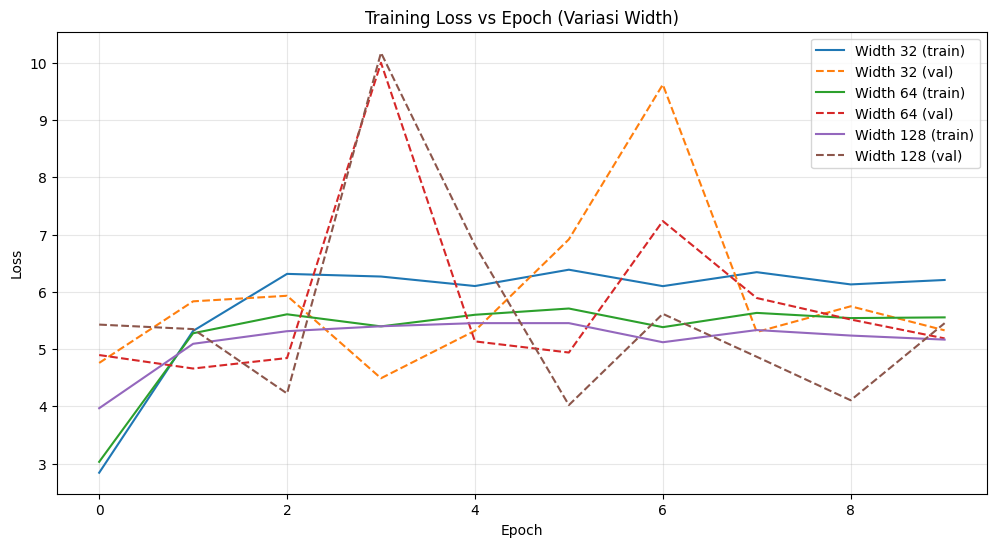

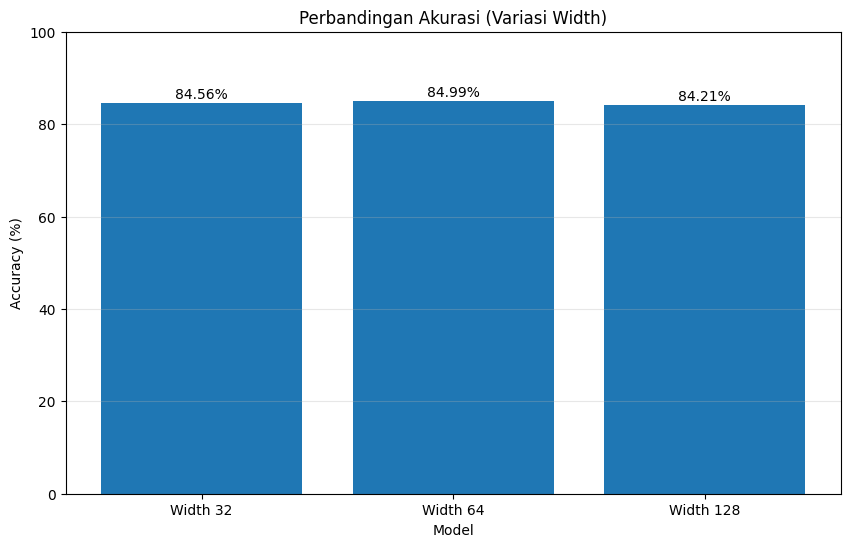

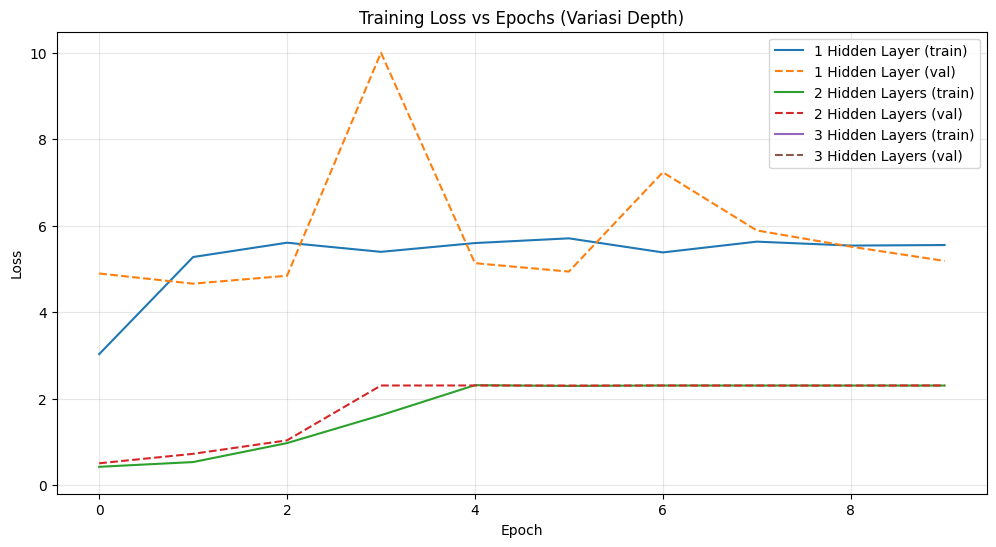

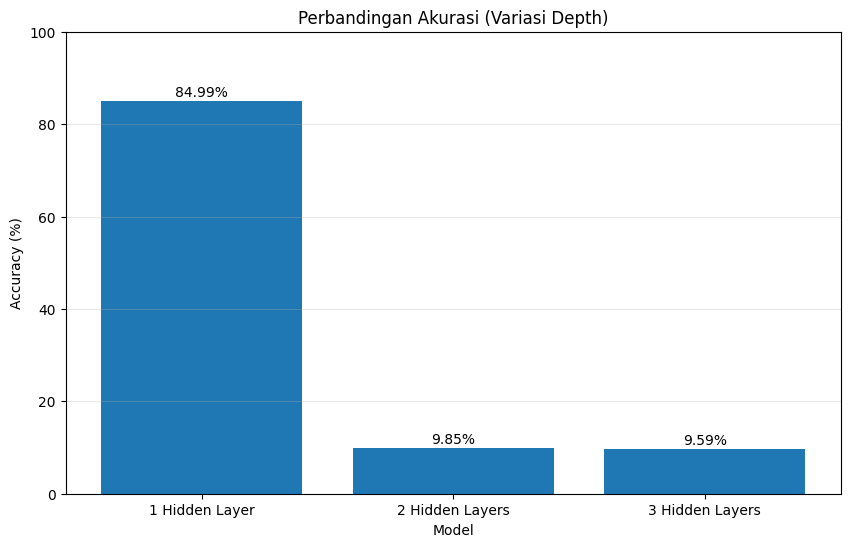

In [5]:
# visualisasi training loss untuk width yang berbeda-beda
plot_training_history(width_results, 'Training Loss vs Epoch (Variasi Width)')

# perbandingan akurasi antar perbedaan width
compare_accuracies(width_results, 'Perbandingan Akurasi (Variasi Width)')

# visualisasi training loss untuk depth yang berbeda-beda
plot_training_history(depth_results, 'Training Loss vs Epochs (Variasi Depth)')

# perbandingan akurasi antar perbedaan depth
compare_accuracies(depth_results, 'Perbandingan Akurasi (Variasi Depth)')

### 2. Analisis Pengaruh Fungsi Aktivasi

In [6]:
print("\n=== Analisis Pengaruh Fungsi Aktivasi ===")

activation_results = []

activation_configs = [
    {'activation': 'linear', 'label': 'Linear'},
    {'activation': 'relu', 'label': 'ReLU'},
    {'activation': 'sigmoid', 'label': 'Sigmoid'},
    {'activation': 'tanh', 'label': 'Tanh'}
]

for config in activation_configs:
    print(f"\nModel dengan {config['label']} activation")
    model = FeedForwardNN(
        layer_dimensions=[784, 64, 10],
        activations=[config['activation'], 'softmax'],
        loss='categorical_cross_entropy',
        weight_initializer='random_normal',
        weight_init_params={'mean': 0.0, 'variance': 0.01, 'seed': 42}
    )
    
    result = train_and_evaluate(
        model, X_train, y_train, X_test, y_test, **common_params
    )
    
    result['label'] = config['label']
    activation_results.append(result)
    print(f"Akurasi: {result['accuracy'] * 100:.2f}%, Waktu latih: {result['training_time']:.2f} detik")


=== Analisis Pengaruh Fungsi Aktivasi ===

Model dengan Linear activation
Epoch 1/10 - Train Loss: 8.5966 - Val Loss: 10.8328
Epoch 2/10 - Train Loss: 9.7042 - Val Loss: 8.1289
Epoch 3/10 - Train Loss: 9.7023 - Val Loss: 8.2227
Epoch 4/10 - Train Loss: 9.6079 - Val Loss: 14.3583
Epoch 5/10 - Train Loss: 9.8362 - Val Loss: 9.6585
Epoch 6/10 - Train Loss: 9.7665 - Val Loss: 10.8575
Epoch 7/10 - Train Loss: 9.6326 - Val Loss: 11.2202
Epoch 8/10 - Train Loss: 9.8658 - Val Loss: 8.1684
Epoch 9/10 - Train Loss: 9.7307 - Val Loss: 10.1125
Epoch 10/10 - Train Loss: 9.6332 - Val Loss: 11.1338
Akurasi: 67.76%, Waktu latih: 15.05 detik

Model dengan ReLU activation
Epoch 1/10 - Train Loss: 3.0297 - Val Loss: 4.8953
Epoch 2/10 - Train Loss: 5.2762 - Val Loss: 4.6598
Epoch 3/10 - Train Loss: 5.6072 - Val Loss: 4.8429
Epoch 4/10 - Train Loss: 5.3961 - Val Loss: 10.0014
Epoch 5/10 - Train Loss: 5.5990 - Val Loss: 5.1339
Epoch 6/10 - Train Loss: 5.7081 - Val Loss: 4.9392
Epoch 7/10 - Train Loss: 5.38

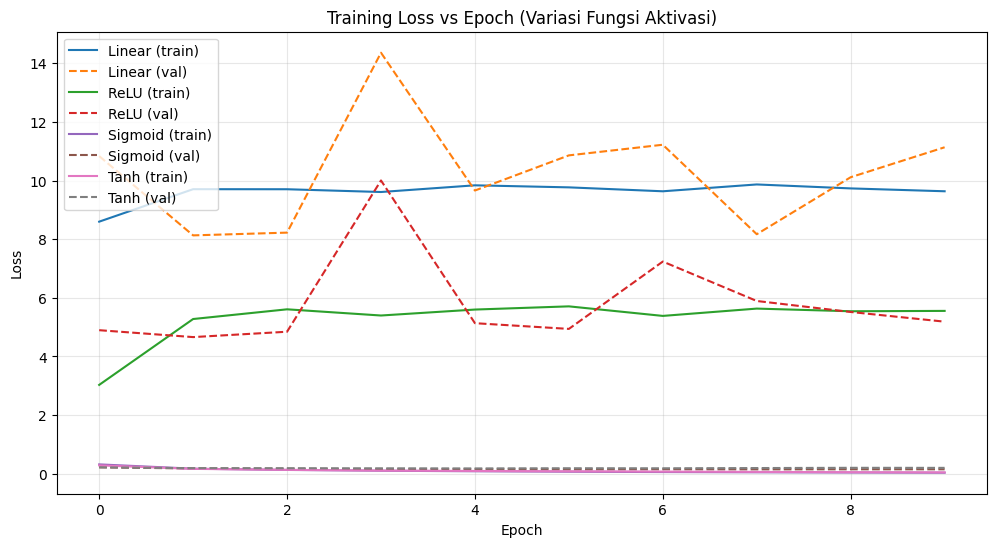

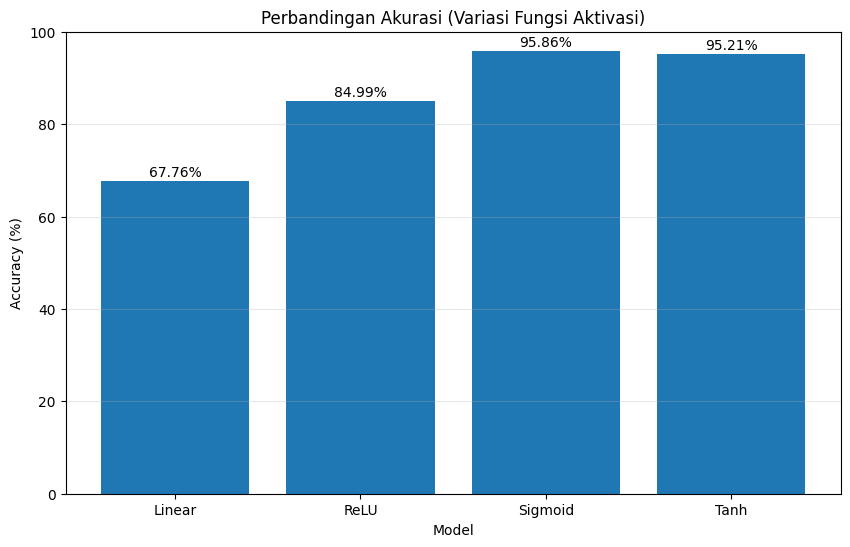

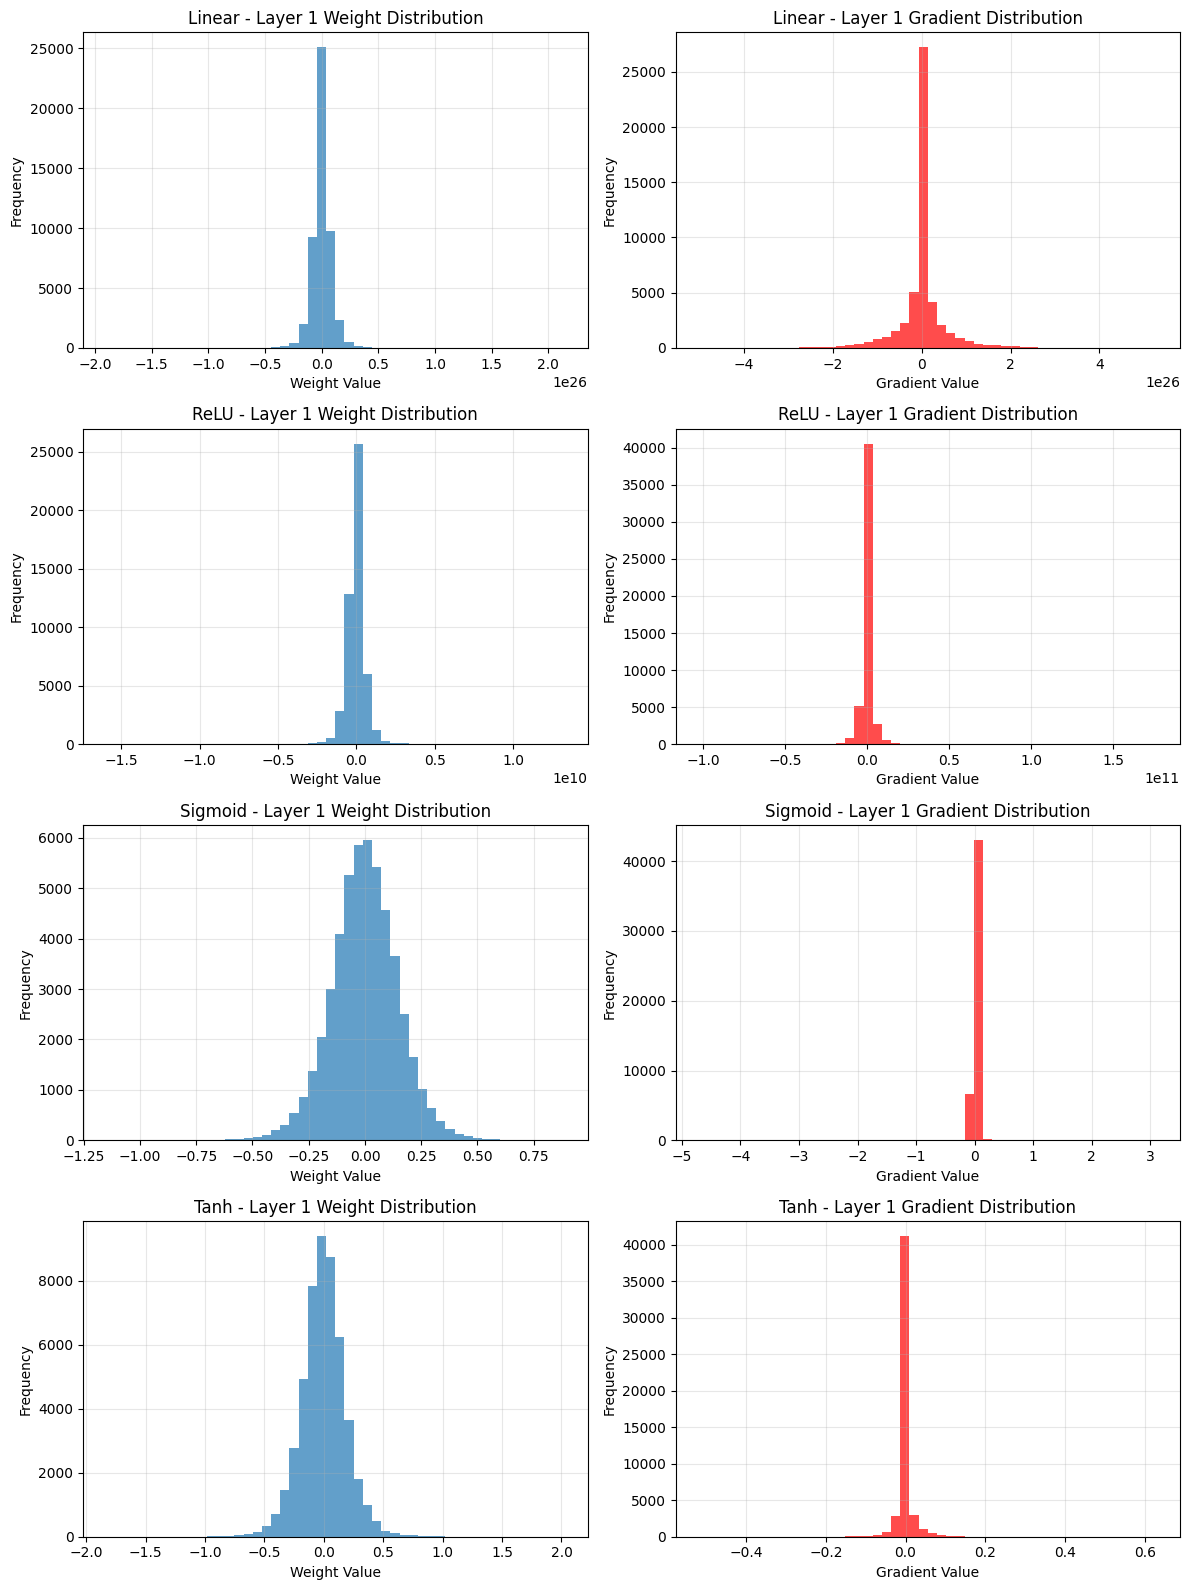

In [7]:
# training loss untuk berbagai fungsi aktivasi
plot_training_history(activation_results, 'Training Loss vs Epoch (Variasi Fungsi Aktivasi)')

# perbandingan akurasi antar perbedaan fungsi aktivasi
compare_accuracies(activation_results, 'Perbandingan Akurasi (Variasi Fungsi Aktivasi)')

# perbandingan weight dan gradien
compare_weights_and_gradients(activation_results, layer_idx=0)

### 3. Analisis Pengaruh Learning Rate

In [8]:
print("\n=== Analisis Pengaruh Learning Rate ===")

lr_results = []

learning_rates = [0.001, 0.005, 0.01]

for lr in learning_rates:
    print(f"\nModel dengan learning rate {lr}")
    model = FeedForwardNN(
        layer_dimensions=[784, 64, 10],
        activations=['relu', 'softmax'],
        loss='categorical_cross_entropy',
        weight_initializer='random_normal',
        weight_init_params={'mean': 0.0, 'variance': 0.01, 'seed': 42}
    )
    
    params = common_params.copy()
    params['learning_rate'] = lr
    
    result = train_and_evaluate(
        model, X_train, y_train, X_test, y_test, **params
    )
    
    result['label'] = f'LR {lr}'
    lr_results.append(result)
    print(f"Akurasi: {result['accuracy'] * 100:.2f}%, Waktu latih: {result['training_time']:.2f} detik")


=== Analisis Pengaruh Learning Rate ===

Model dengan learning rate 0.001
Epoch 1/10 - Train Loss: 0.4154 - Val Loss: 0.2710
Epoch 2/10 - Train Loss: 0.2064 - Val Loss: 0.2087
Epoch 3/10 - Train Loss: 0.1546 - Val Loss: 0.1992
Epoch 4/10 - Train Loss: 0.1269 - Val Loss: 0.1760
Epoch 5/10 - Train Loss: 0.1054 - Val Loss: 0.1674
Epoch 6/10 - Train Loss: 0.0902 - Val Loss: 0.1669
Epoch 7/10 - Train Loss: 0.0783 - Val Loss: 0.1633
Epoch 8/10 - Train Loss: 0.0669 - Val Loss: 0.1610
Epoch 9/10 - Train Loss: 0.0589 - Val Loss: 0.1563
Epoch 10/10 - Train Loss: 0.0505 - Val Loss: 0.1592
Akurasi: 96.17%, Waktu latih: 12.72 detik

Model dengan learning rate 0.005
Epoch 1/10 - Train Loss: 0.4218 - Val Loss: 0.3405
Epoch 2/10 - Train Loss: 0.3785 - Val Loss: 0.3892
Epoch 3/10 - Train Loss: 0.3520 - Val Loss: 0.3533
Epoch 4/10 - Train Loss: 0.2976 - Val Loss: 0.4281
Epoch 5/10 - Train Loss: 0.2510 - Val Loss: 0.4121
Epoch 6/10 - Train Loss: 0.2454 - Val Loss: 0.3812
Epoch 7/10 - Train Loss: 0.1836 

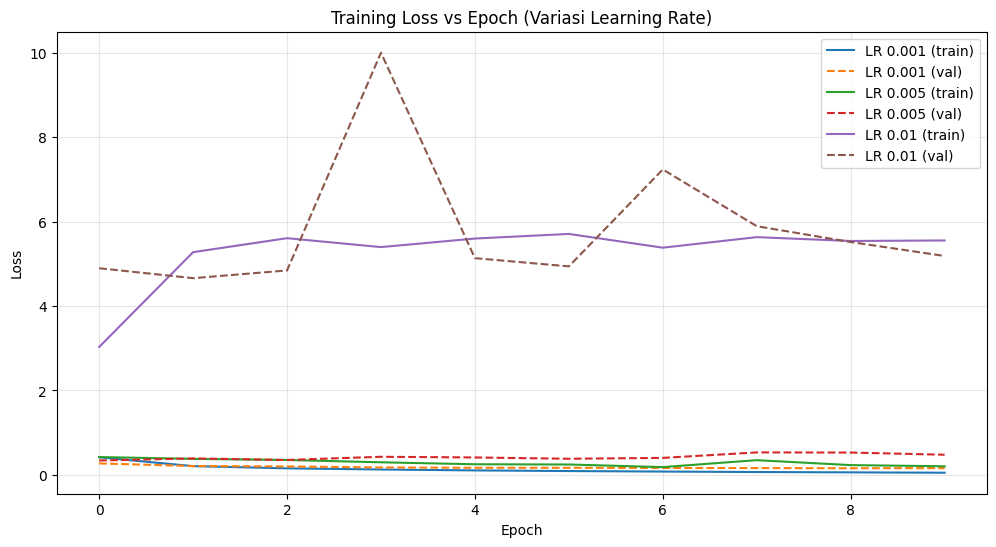

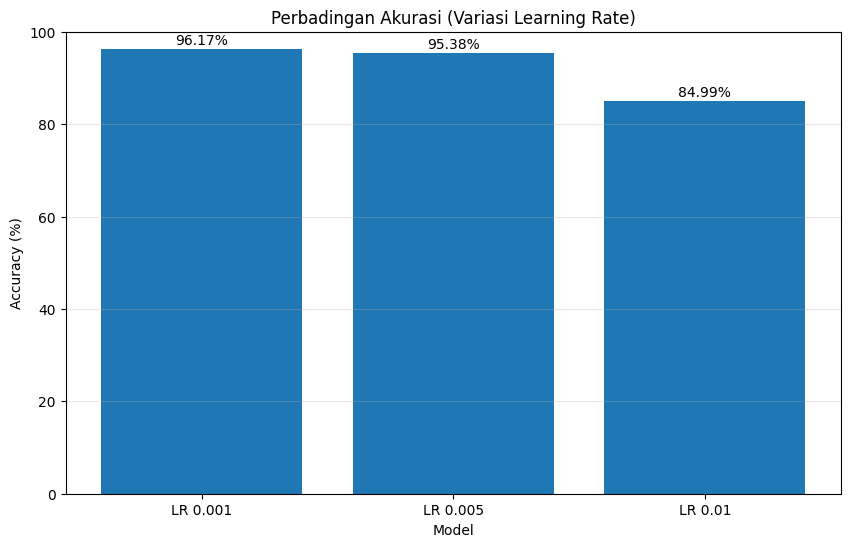

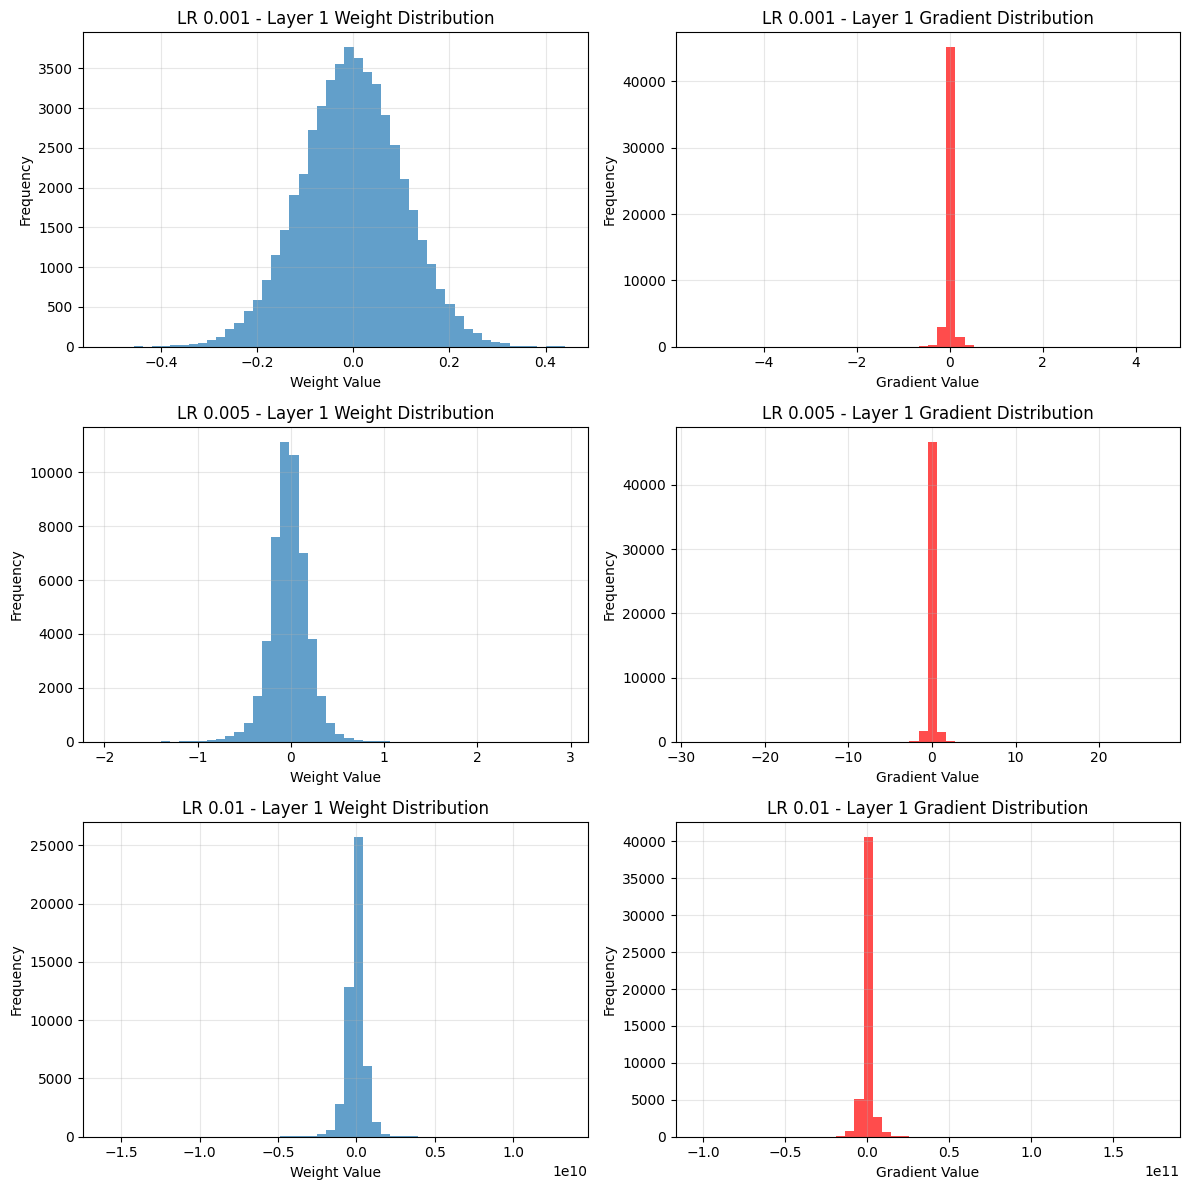

In [9]:
# training loss untuk berbagai learning rate
plot_training_history(lr_results, 'Training Loss vs Epoch (Variasi Learning Rate)')

# perbandingan akurasi antar learning rate
compare_accuracies(lr_results, 'Perbadingan Akurasi (Variasi Learning Rate)')

# perbandingan weight dan gradien
compare_weights_and_gradients(lr_results, layer_idx=0)

### 4. Analisis Pengaruh Metode Inisialisasi Bobot

In [10]:
print("\n=== Analisis Pengaruh Metode Inisialisasi Bobot ===")

init_results = []

init_configs = [
    {
        'initializer': 'zero',
        'params': None,
        'label': 'Zero Initialization'
    },
    {
        'initializer': 'random_uniform',
        'params': {'lower_bound': -0.05, 'upper_bound': 0.05, 'seed': 42},
        'label': 'Random Uniform'
    },
    {
        'initializer': 'random_normal',
        'params': {'mean': 0.0, 'variance': 0.01, 'seed': 42},
        'label': 'Random Normal'
    }
]

for config in init_configs:
    print(f"\nModel dengan {config['label']}")
    model = FeedForwardNN(
        layer_dimensions=[784, 64, 10],
        activations=['relu', 'softmax'],
        loss='categorical_cross_entropy',
        weight_initializer=config['initializer'],
        weight_init_params=config['params']
    )
    
    result = train_and_evaluate(
        model, X_train, y_train, X_test, y_test, **common_params
    )
    
    result['label'] = config['label']
    init_results.append(result)
    print(f"Akurasi: {result['accuracy'] * 100:.2f}%, Waktu latih: {result['training_time']:.2f} detik")


=== Analisis Pengaruh Metode Inisialisasi Bobot ===

Model dengan Zero Initialization
Epoch 1/10 - Train Loss: 2.3038 - Val Loss: 2.3023
Epoch 2/10 - Train Loss: 2.3039 - Val Loss: 2.3043
Epoch 3/10 - Train Loss: 2.3036 - Val Loss: 2.3024
Epoch 4/10 - Train Loss: 2.3035 - Val Loss: 2.3029
Epoch 5/10 - Train Loss: 2.3037 - Val Loss: 2.3015
Epoch 6/10 - Train Loss: 2.3035 - Val Loss: 2.3026
Epoch 7/10 - Train Loss: 2.3037 - Val Loss: 2.3023
Epoch 8/10 - Train Loss: 2.3037 - Val Loss: 2.3027
Epoch 9/10 - Train Loss: 2.3037 - Val Loss: 2.3036
Epoch 10/10 - Train Loss: 2.3036 - Val Loss: 2.3030
Akurasi: 11.43%, Waktu latih: 14.02 detik

Model dengan Random Uniform
Epoch 1/10 - Train Loss: 1.8373 - Val Loss: 4.9734
Epoch 2/10 - Train Loss: 5.1440 - Val Loss: 5.4074
Epoch 3/10 - Train Loss: 5.5331 - Val Loss: 5.4744
Epoch 4/10 - Train Loss: 5.3159 - Val Loss: 4.4640
Epoch 5/10 - Train Loss: 5.4392 - Val Loss: 4.2581
Epoch 6/10 - Train Loss: 5.5706 - Val Loss: 5.0575
Epoch 7/10 - Train Loss: 

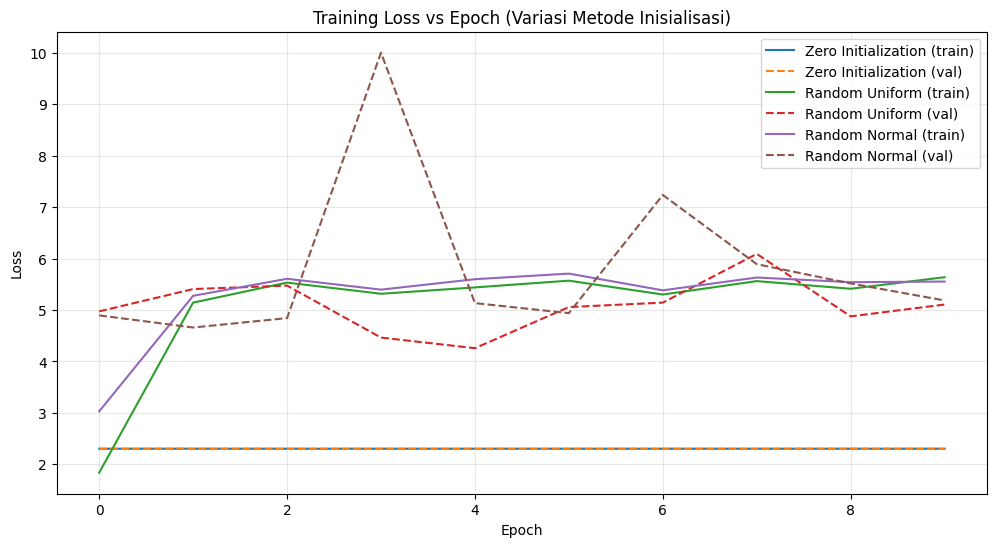

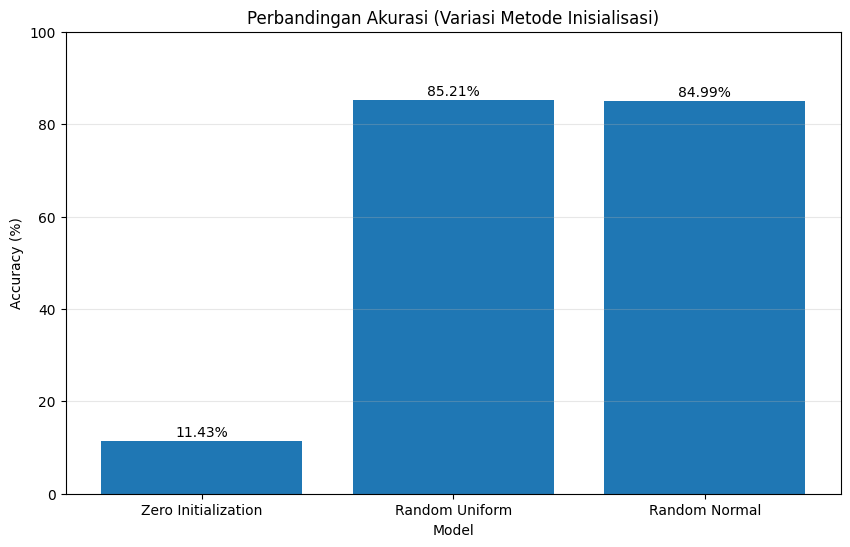

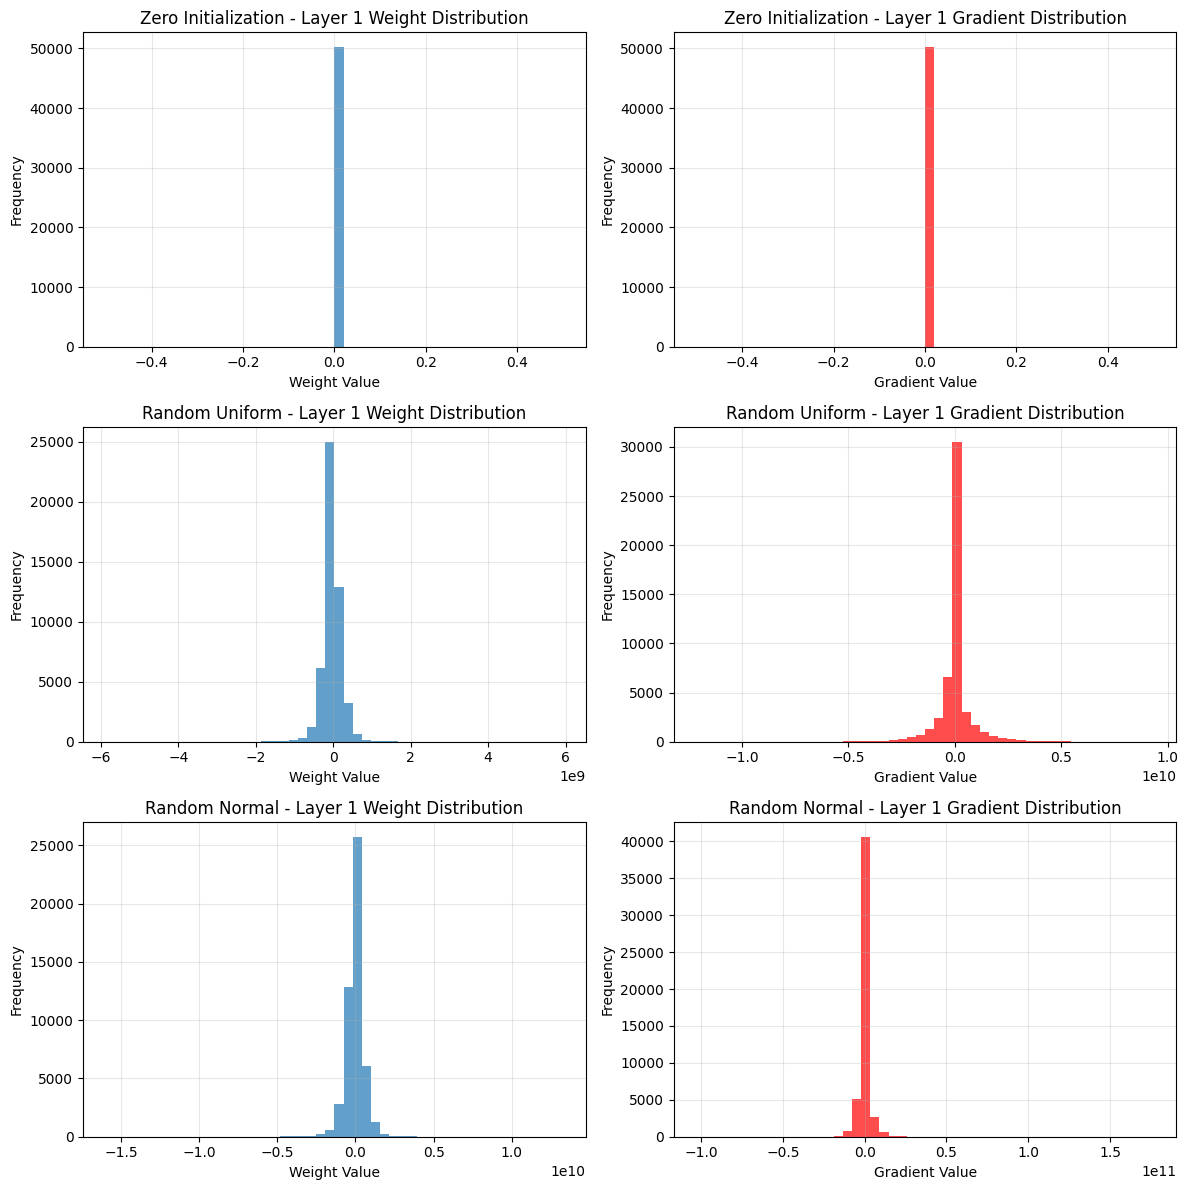

In [11]:
# training loss untuk berbagai metode inisialisasi bobot
plot_training_history(init_results, 'Training Loss vs Epoch (Variasi Metode Inisialisasi)')

# perbandingan akurasi antar metode inisialisasi bobot
compare_accuracies(init_results, 'Perbandingan Akurasi (Variasi Metode Inisialisasi)')

# perbandingan bobot dan gradien
compare_weights_and_gradients(init_results, layer_idx=0)

### 5. Comparison with sklearn's MLP

In [12]:
print("\n=== Perbandingan antara Hasil Implementasi dengan Library ===")

# latih ffnn hasil implementasi
print("\nImplementasi FFNN")
our_model = FeedForwardNN(
    layer_dimensions=[784, 64, 10],
    activations=['relu', 'softmax'],
    loss='categorical_cross_entropy',
    weight_initializer='random_normal',
    weight_init_params={'mean': 0.0, 'variance': 0.01, 'seed': 42}
)

our_result = train_and_evaluate(
    our_model, X_train, y_train, X_test, y_test,
    batch_size=32,
    learning_rate=0.001,
    epochs=10,
    verbose=1
)

# latih MLP dengan param mirip
print("\nMLP")
sklearn_mlp = MLPClassifier(
    hidden_layer_sizes=(64,),
    activation='relu',
    solver='sgd',
    alpha=0.0,
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=10,
    random_state=42
)

start_time = time.time()
sklearn_mlp.fit(X_train, np.argmax(y_train, axis=1))
sklearn_time = time.time() - start_time

sklearn_preds = sklearn_mlp.predict(X_test)
sklearn_accuracy = np.mean(sklearn_preds == np.argmax(y_test, axis=1))

print(f"\nAkurasi Hasil Implementasi FFNN: {our_result['accuracy'] * 100:.2f}%, Waktu latih: {our_result['training_time']:.2f} detik")
print(f"Akurasi MLP sklearn: {sklearn_accuracy * 100:.2f}%, Waktu latih: {sklearn_time:.2f} detik")


=== Perbandingan antara Hasil Implementasi dengan Library ===

Implementasi FFNN
Epoch 1/10 - Train Loss: 0.4154 - Val Loss: 0.2710
Epoch 2/10 - Train Loss: 0.2064 - Val Loss: 0.2087
Epoch 3/10 - Train Loss: 0.1546 - Val Loss: 0.1992
Epoch 4/10 - Train Loss: 0.1269 - Val Loss: 0.1760
Epoch 5/10 - Train Loss: 0.1054 - Val Loss: 0.1674
Epoch 6/10 - Train Loss: 0.0902 - Val Loss: 0.1669
Epoch 7/10 - Train Loss: 0.0783 - Val Loss: 0.1633
Epoch 8/10 - Train Loss: 0.0669 - Val Loss: 0.1610
Epoch 9/10 - Train Loss: 0.0589 - Val Loss: 0.1563
Epoch 10/10 - Train Loss: 0.0505 - Val Loss: 0.1592

MLP

Akurasi Hasil Implementasi FFNN: 96.17%, Waktu latih: 13.91 detik
Akurasi MLP sklearn: 95.88%, Waktu latih: 16.97 detik


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


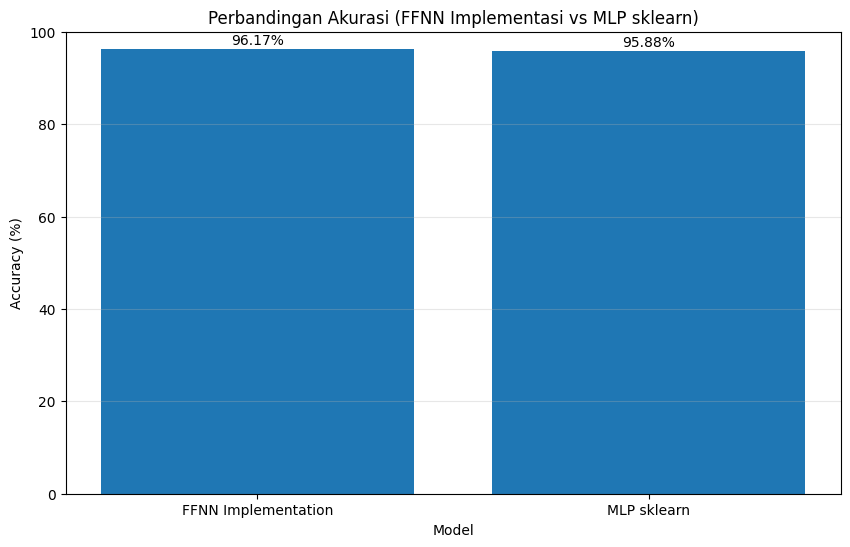

In [13]:
comparison_results = [ {'label': 'FFNN Implementation', 'accuracy': our_result['accuracy']}, {'label': 'MLP sklearn', 'accuracy': sklearn_accuracy} ]
compare_accuracies(comparison_results, 'Perbandingan Akurasi (FFNN Implementasi vs MLP sklearn)')